/home/david/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


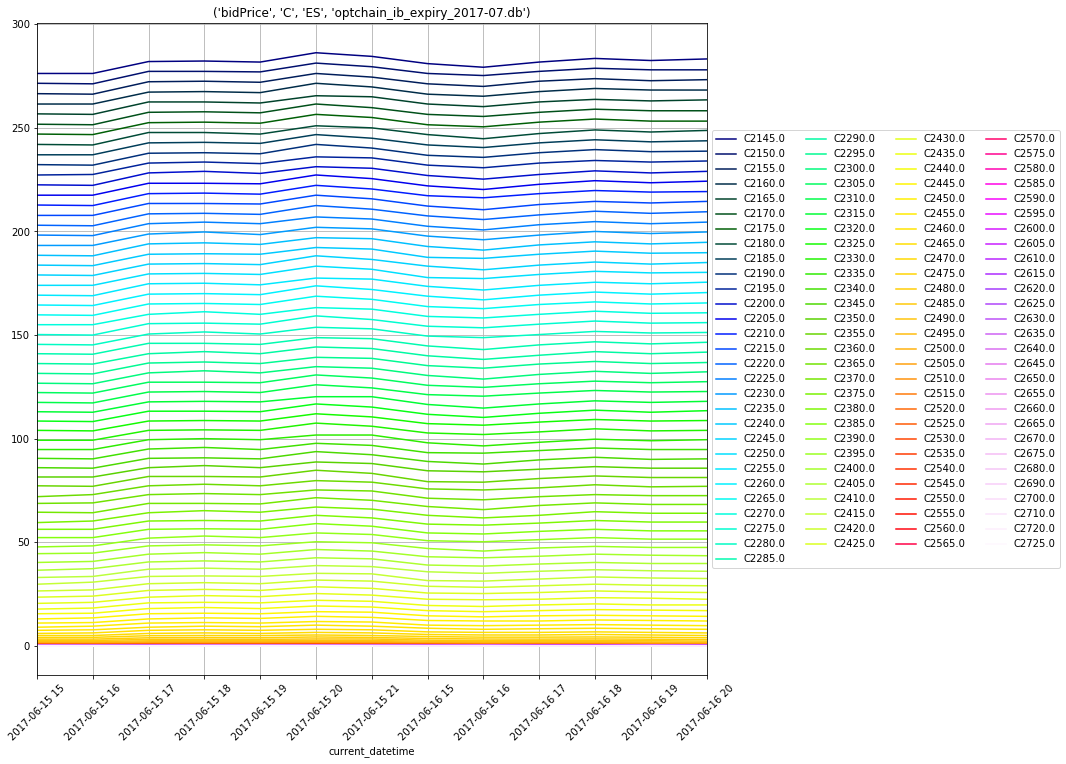

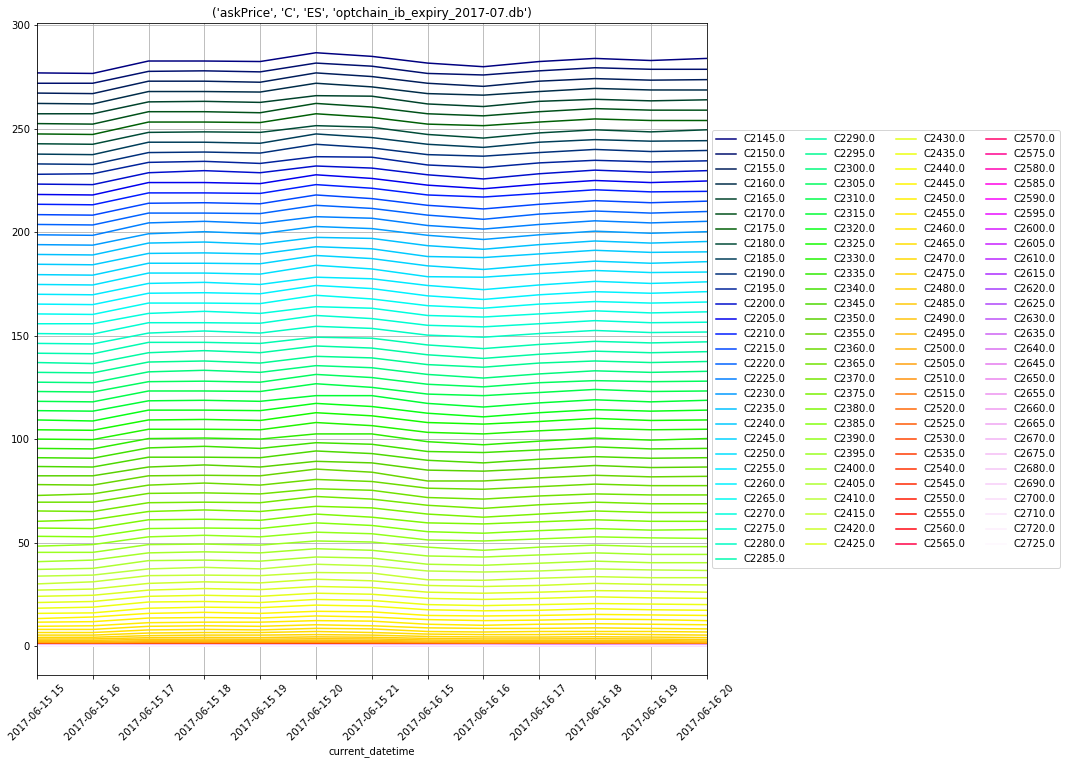

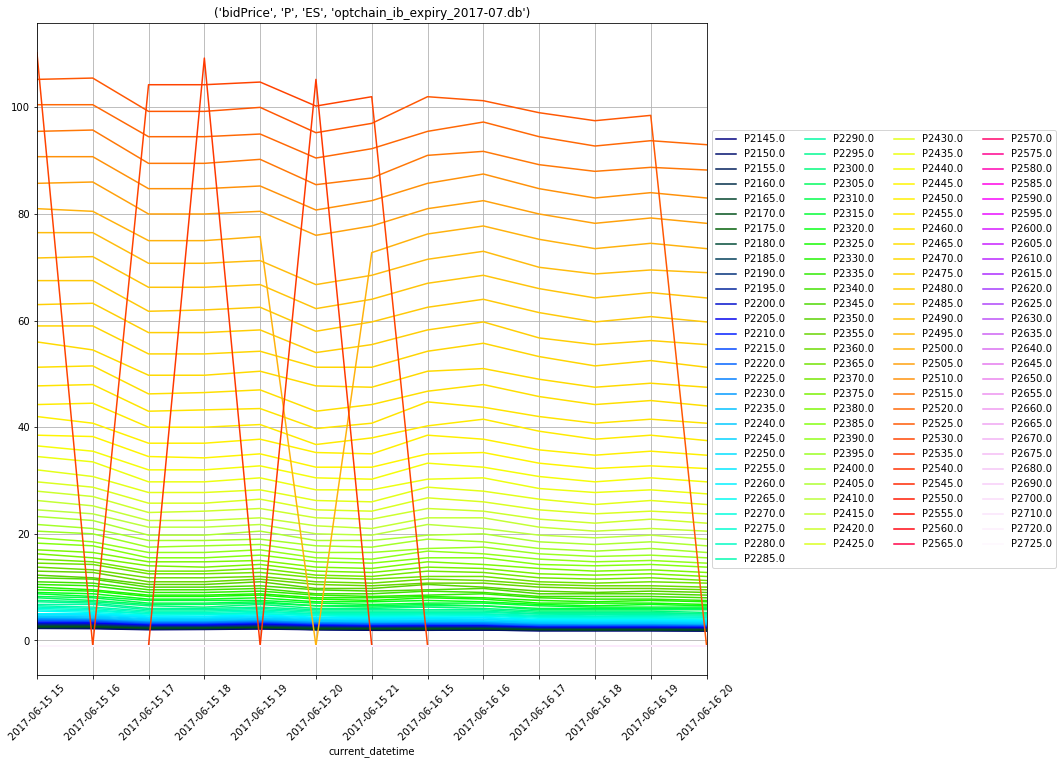

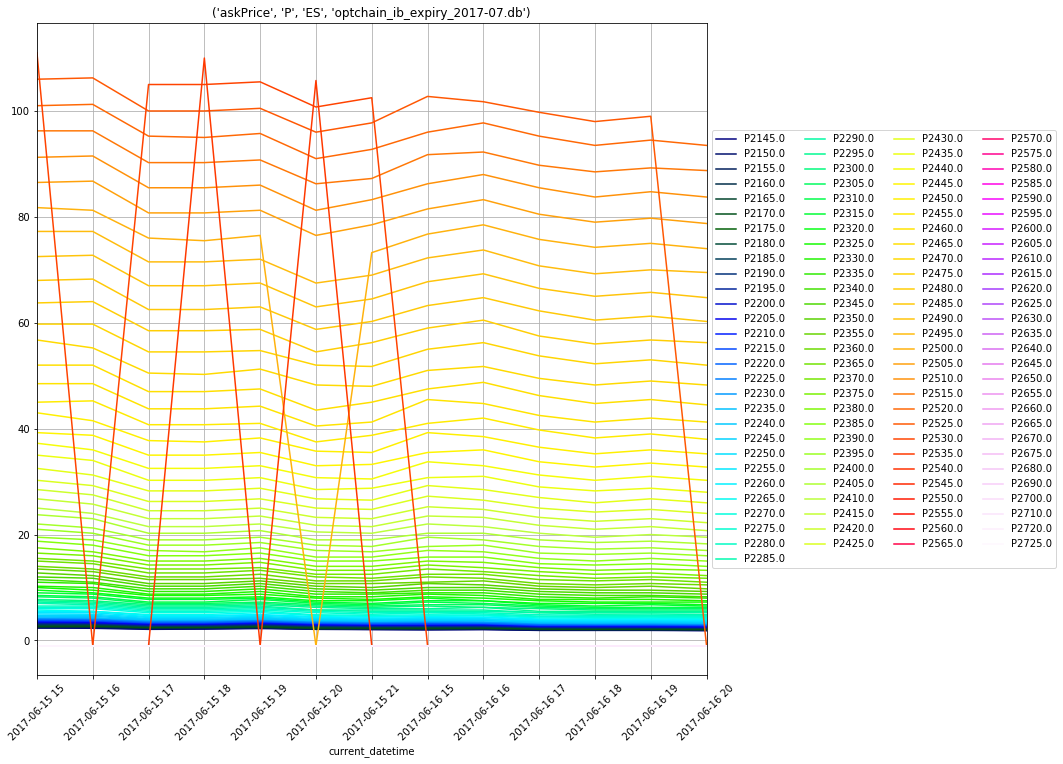

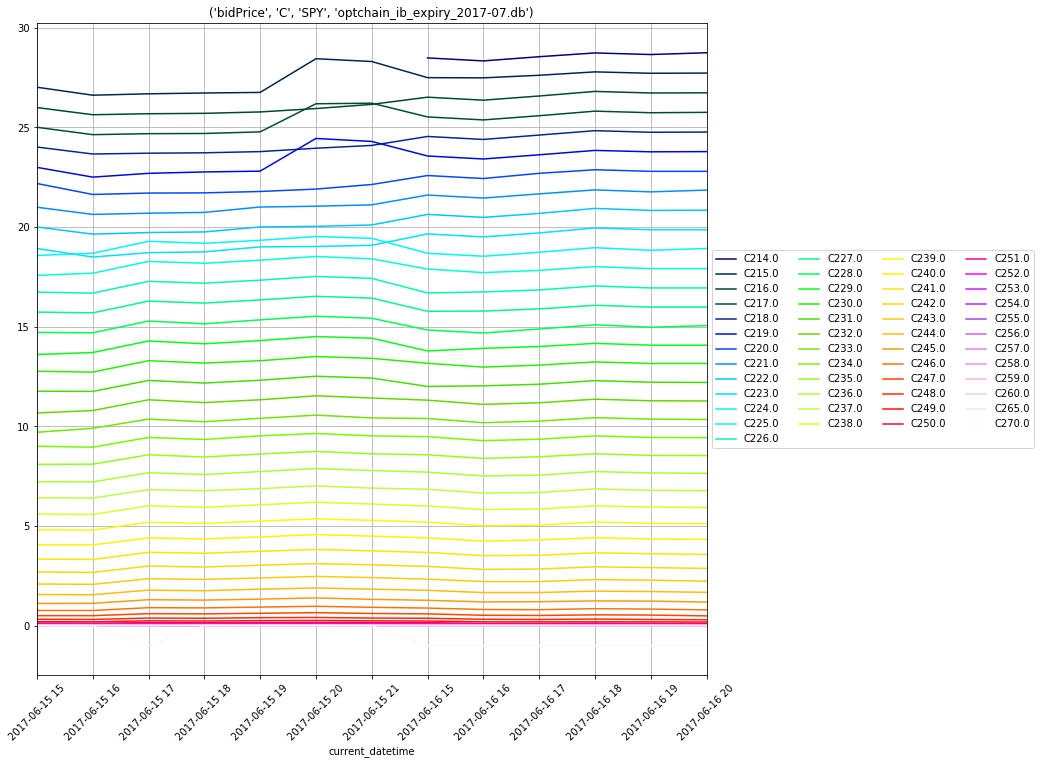

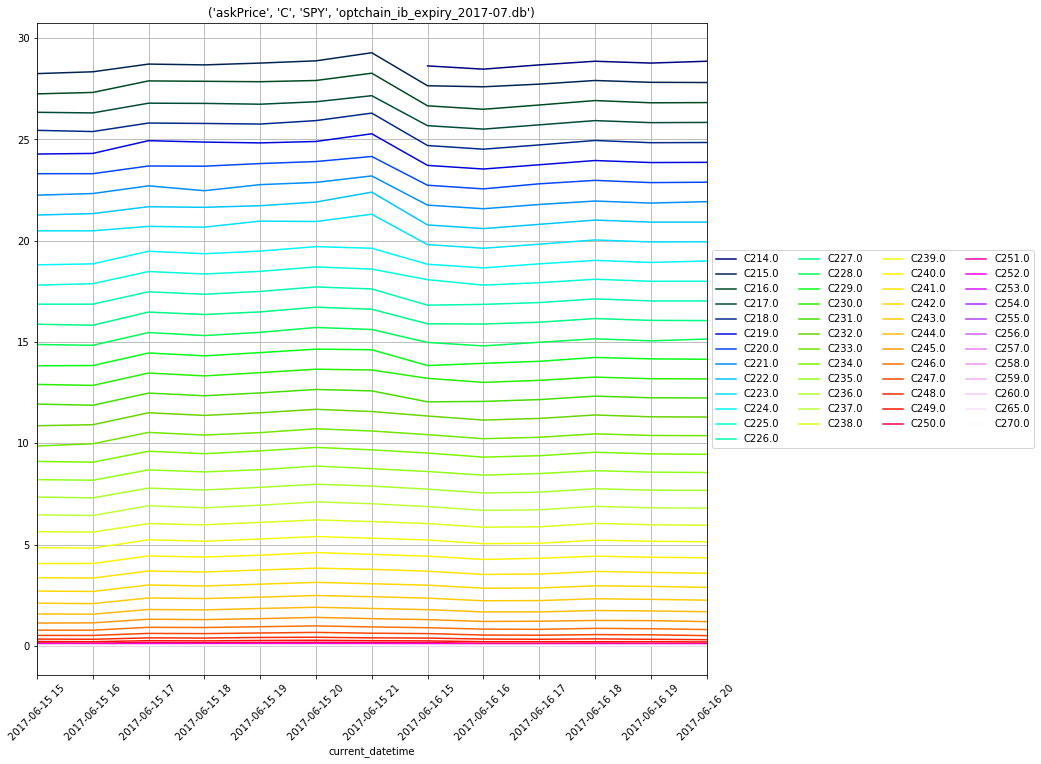

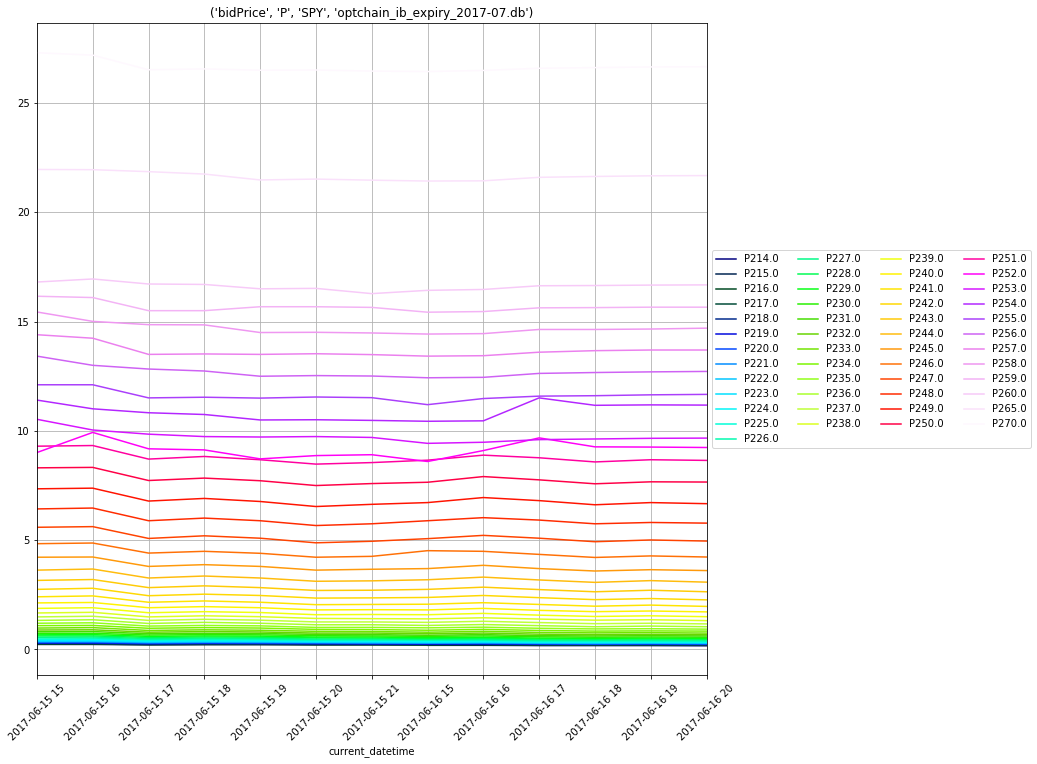

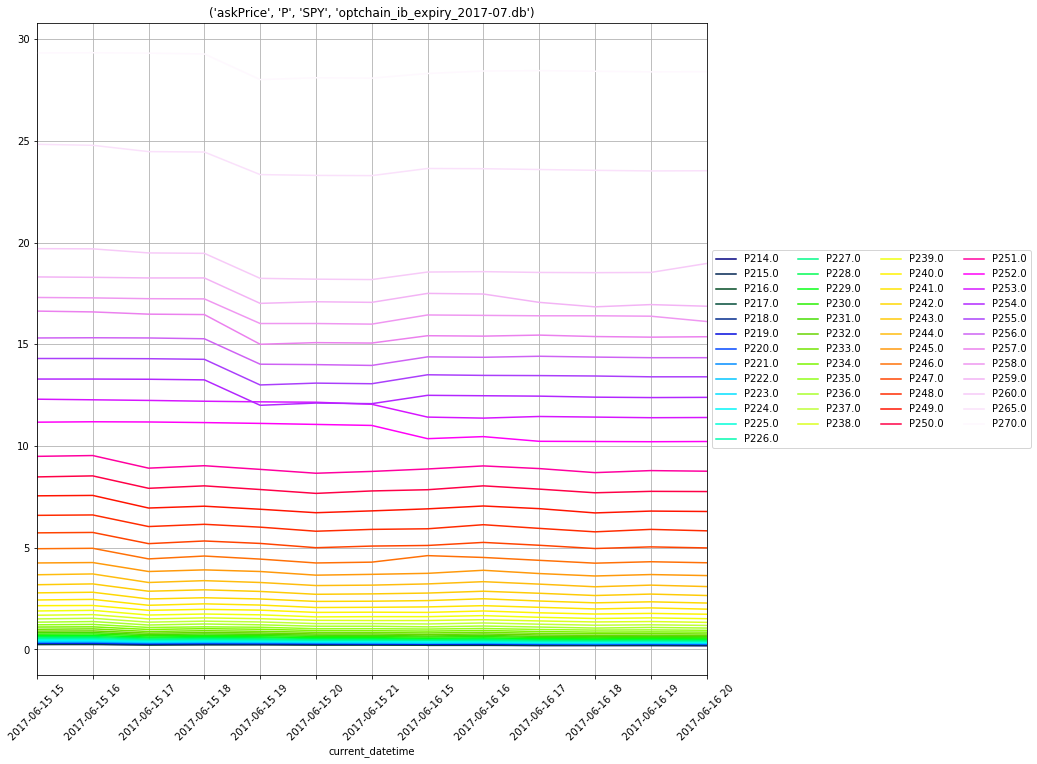

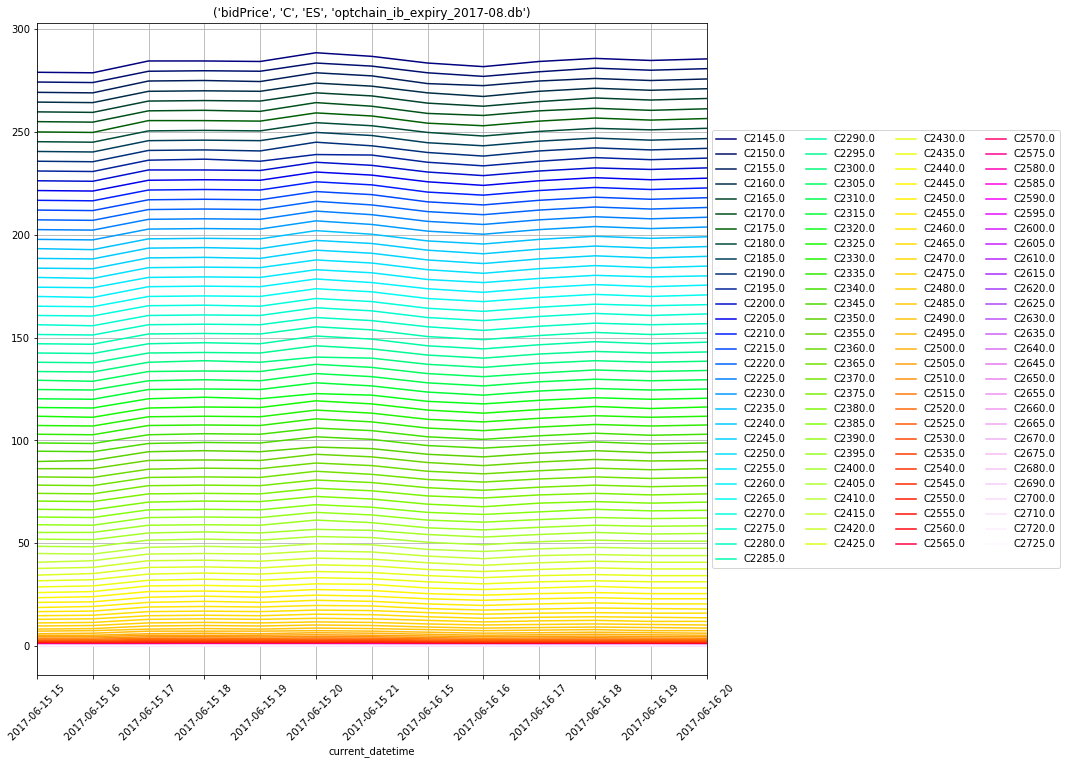

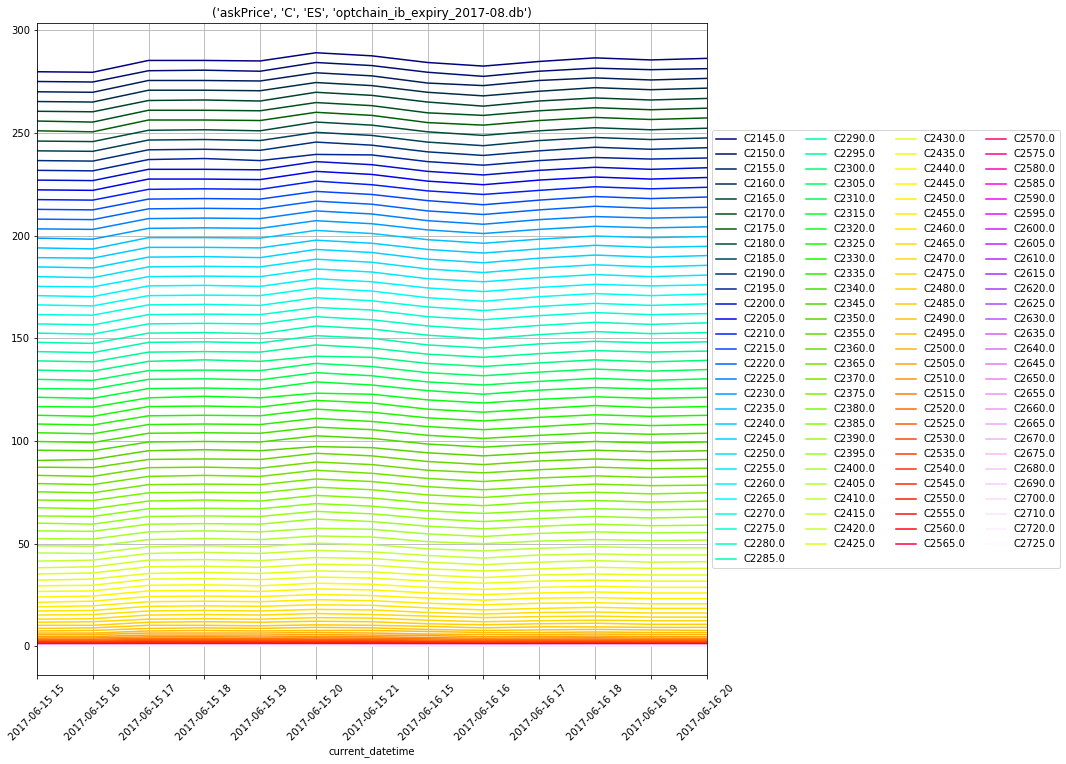

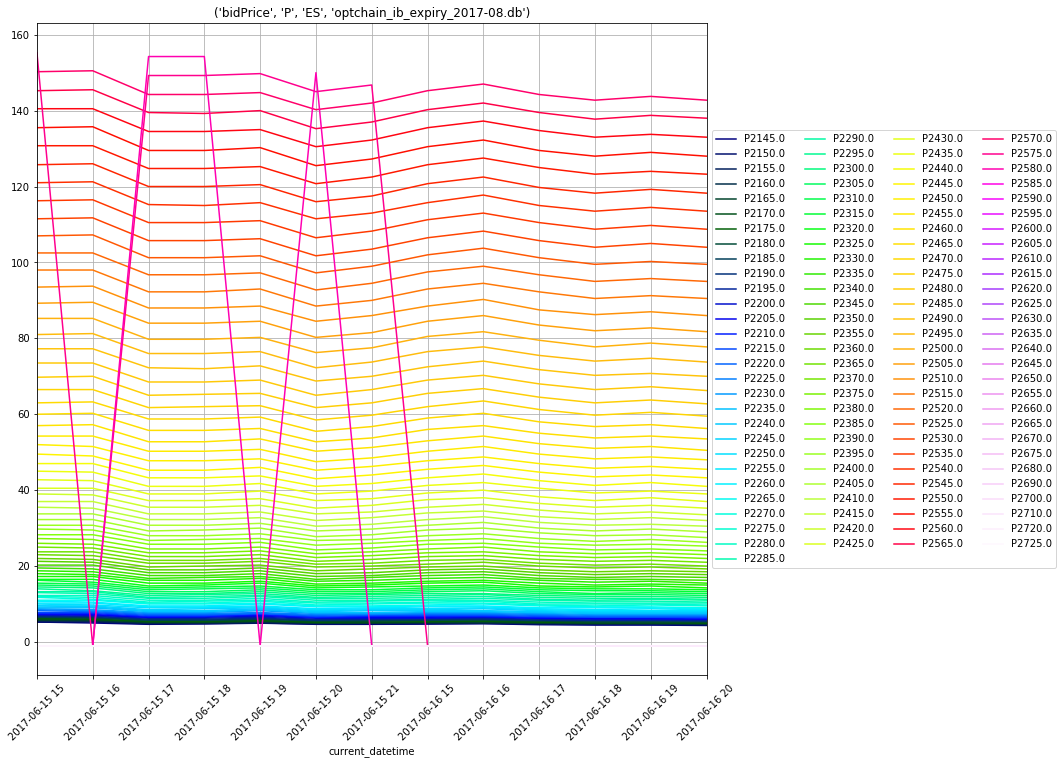

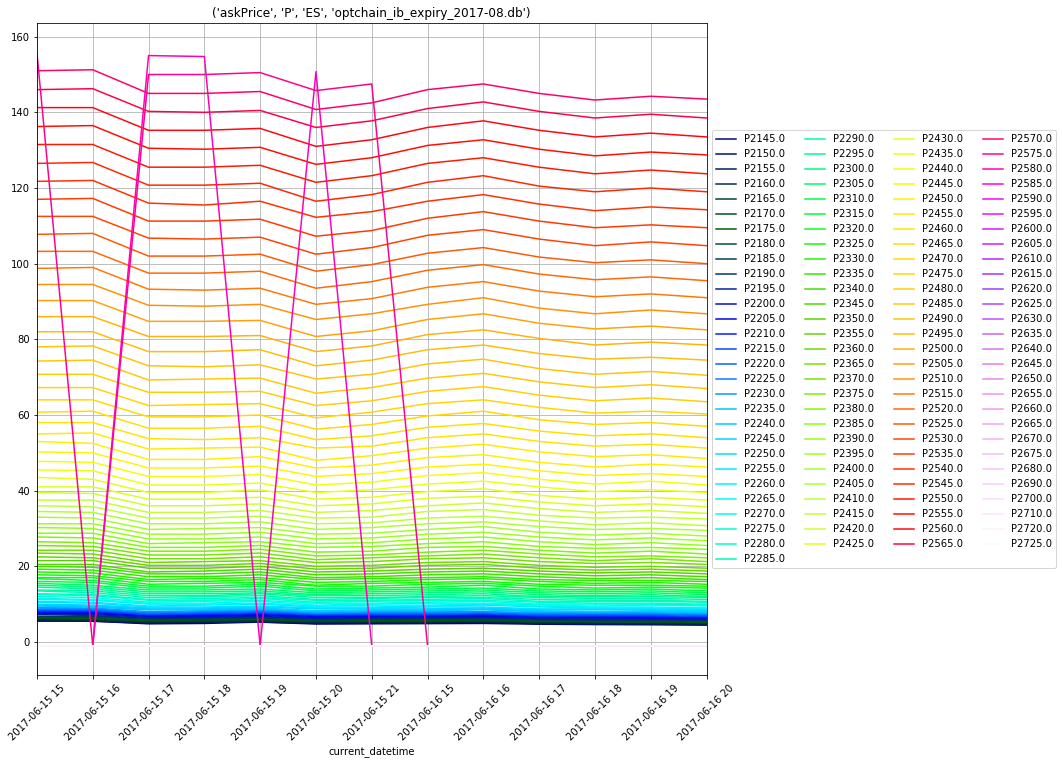

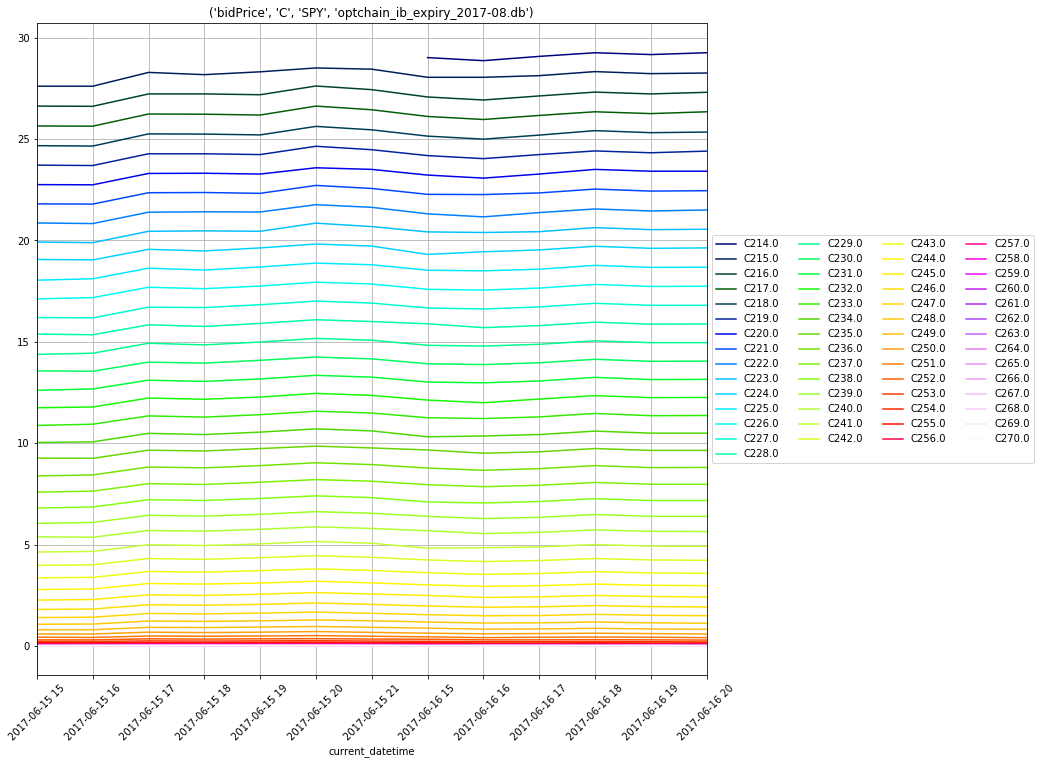

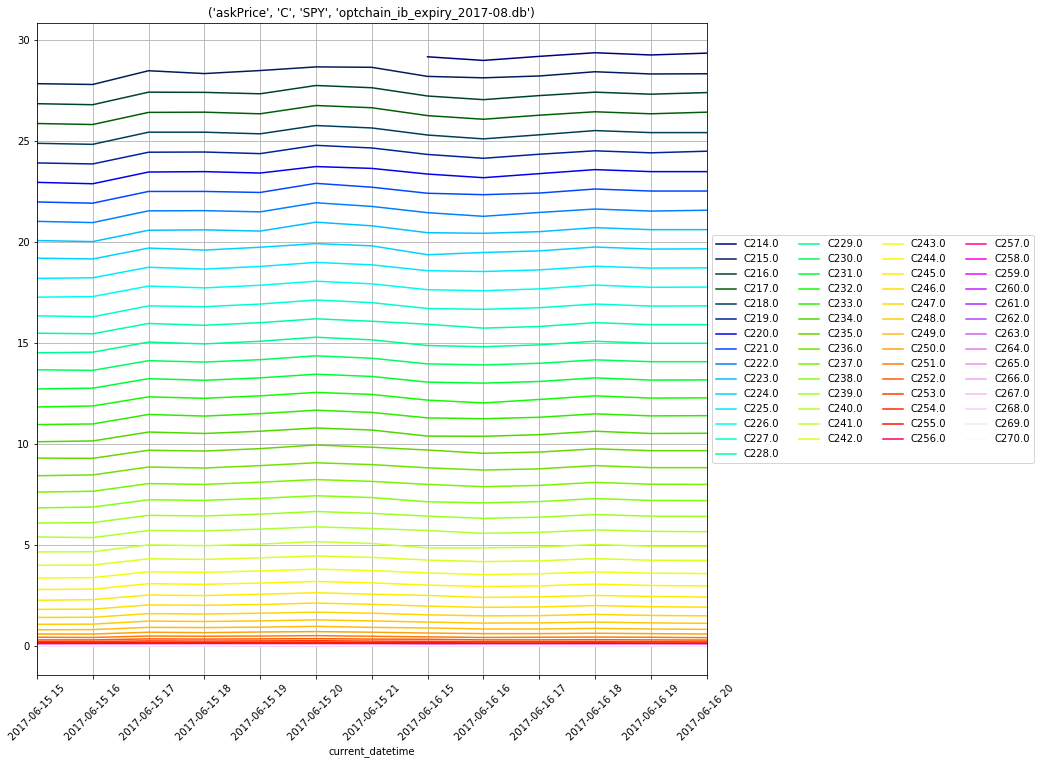

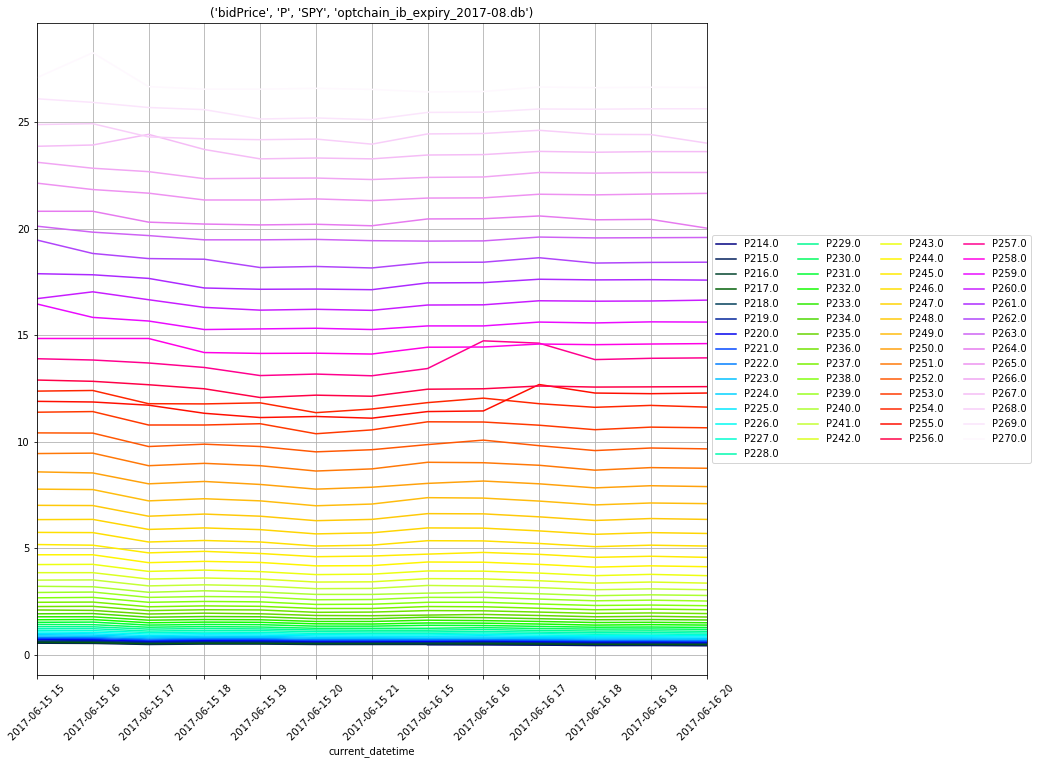

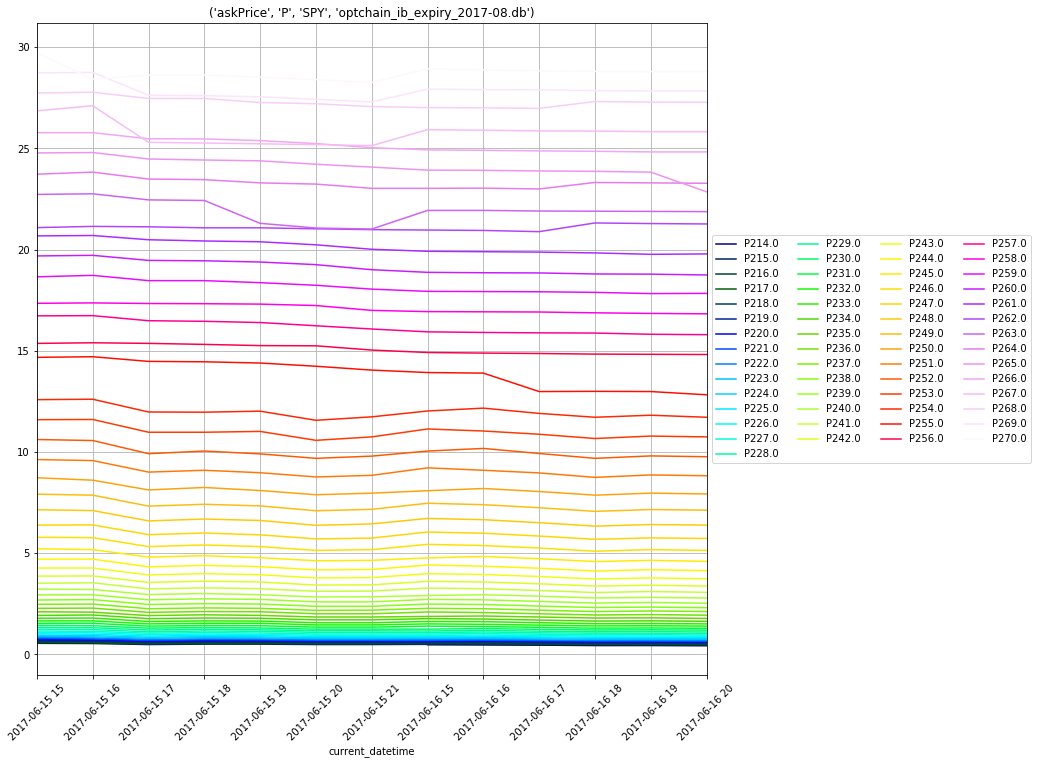

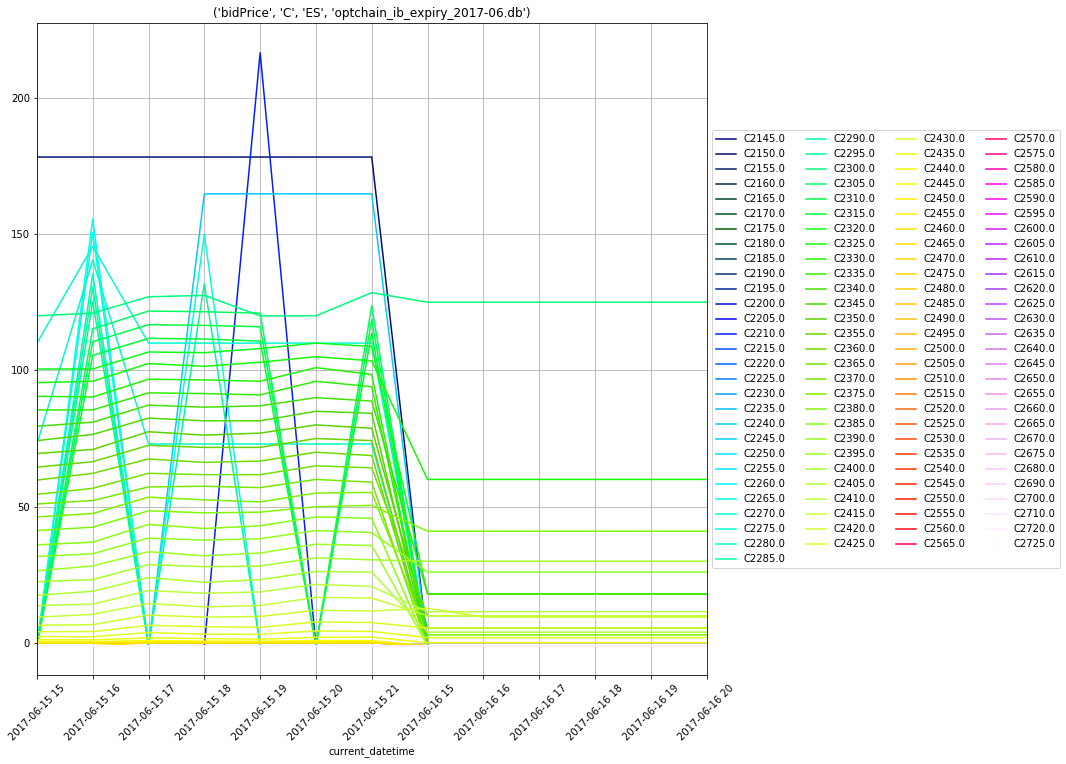

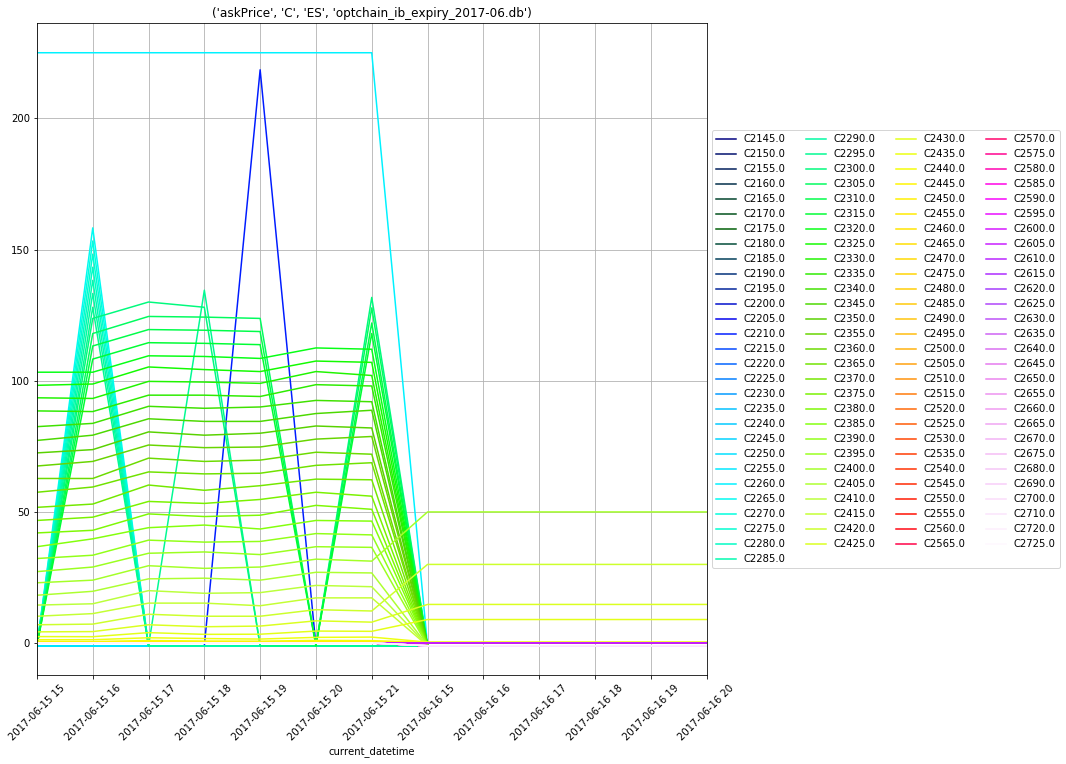

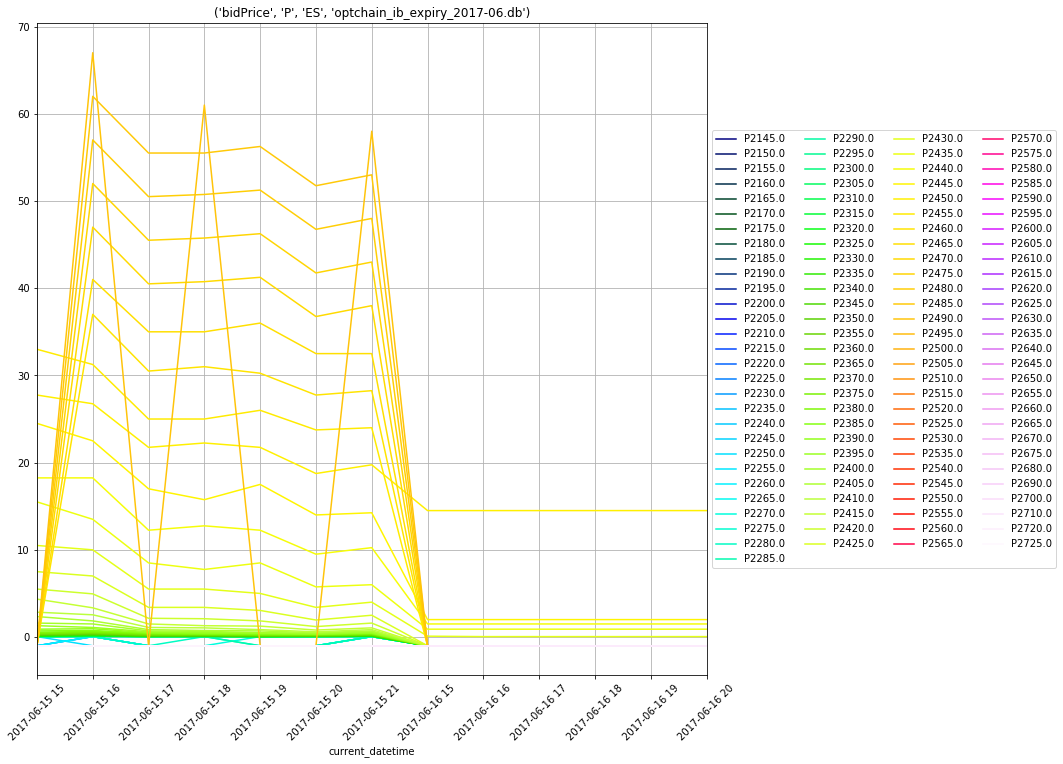

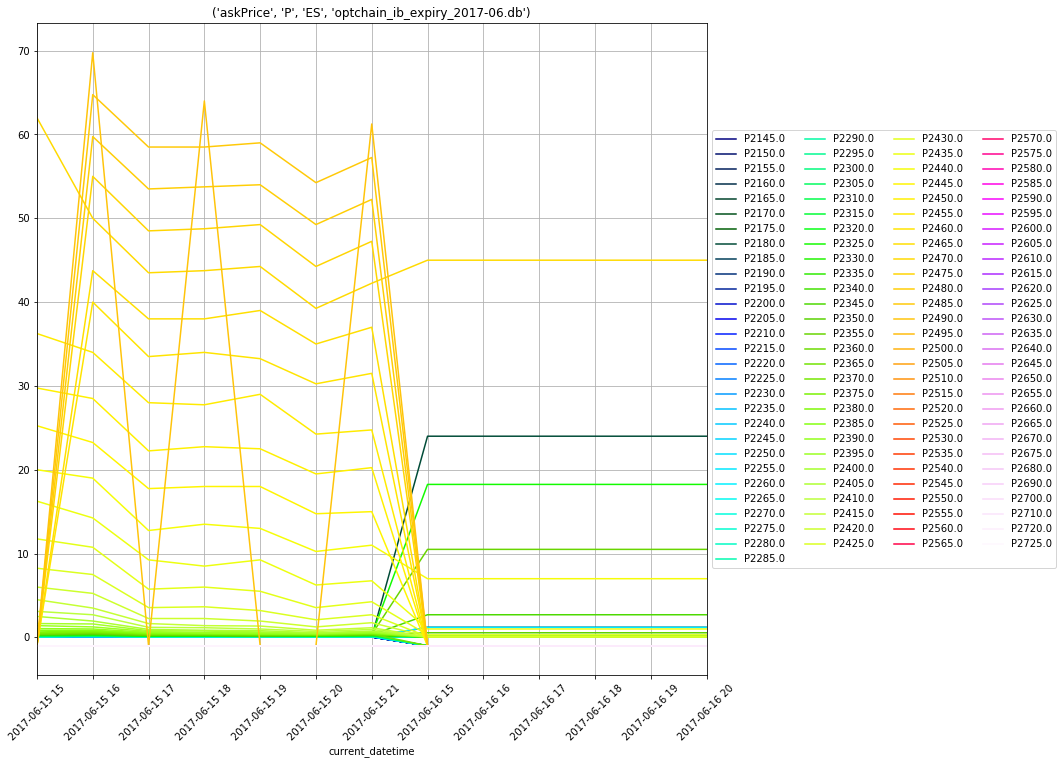

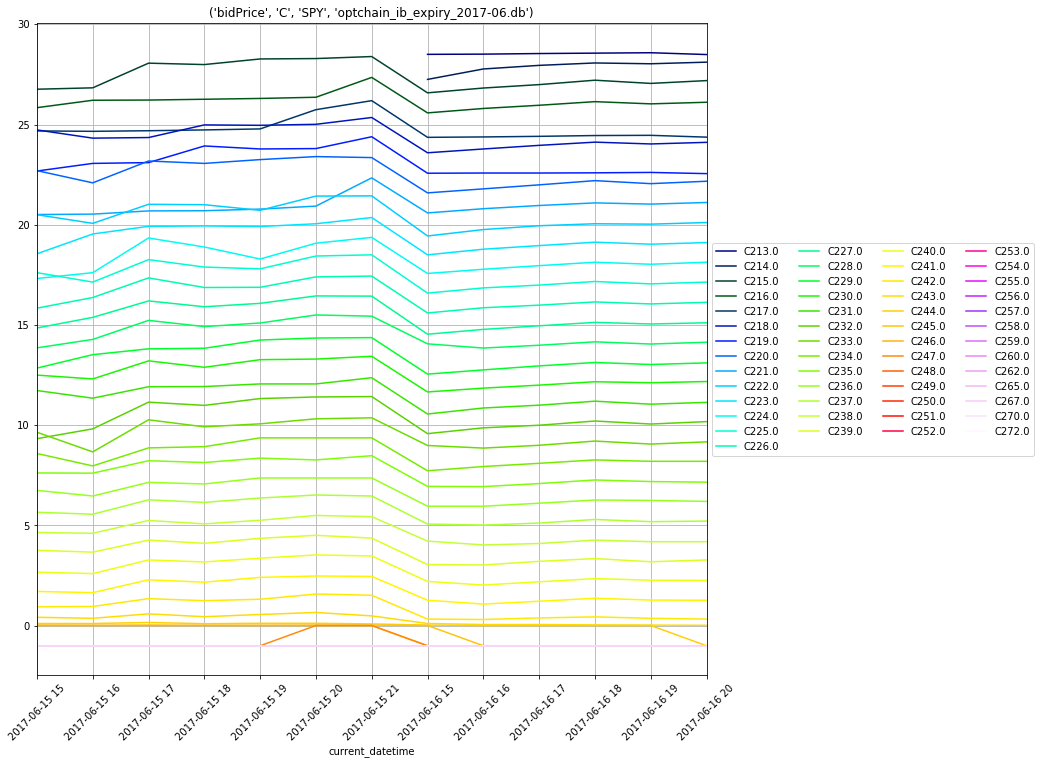

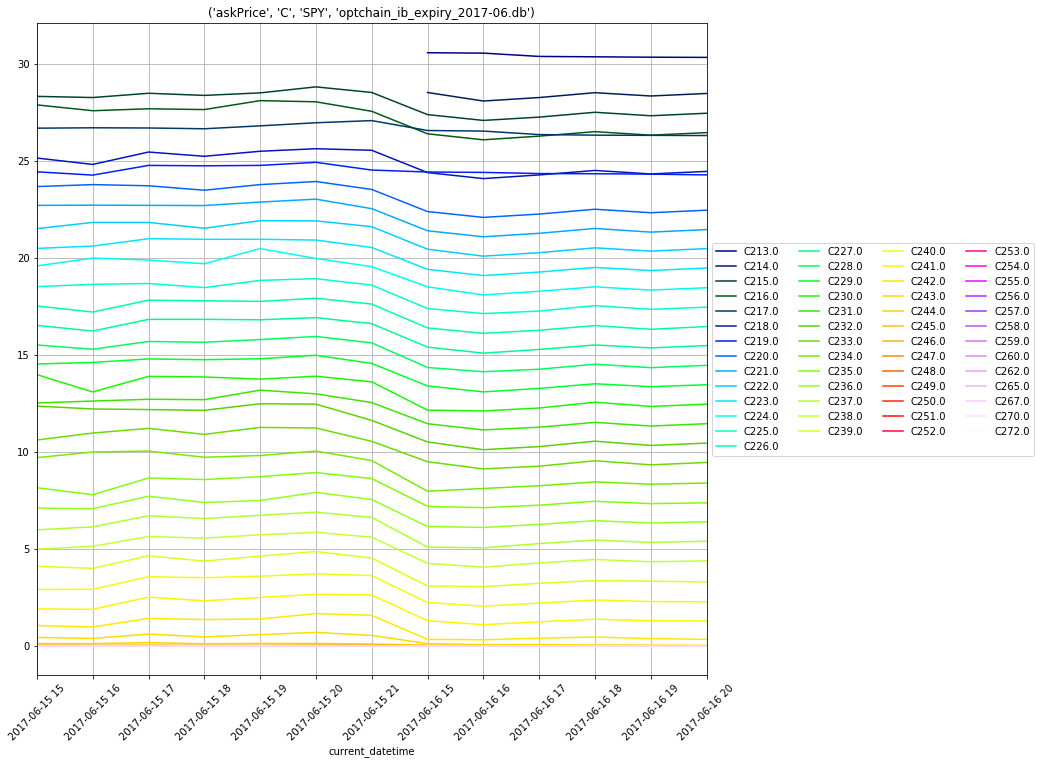

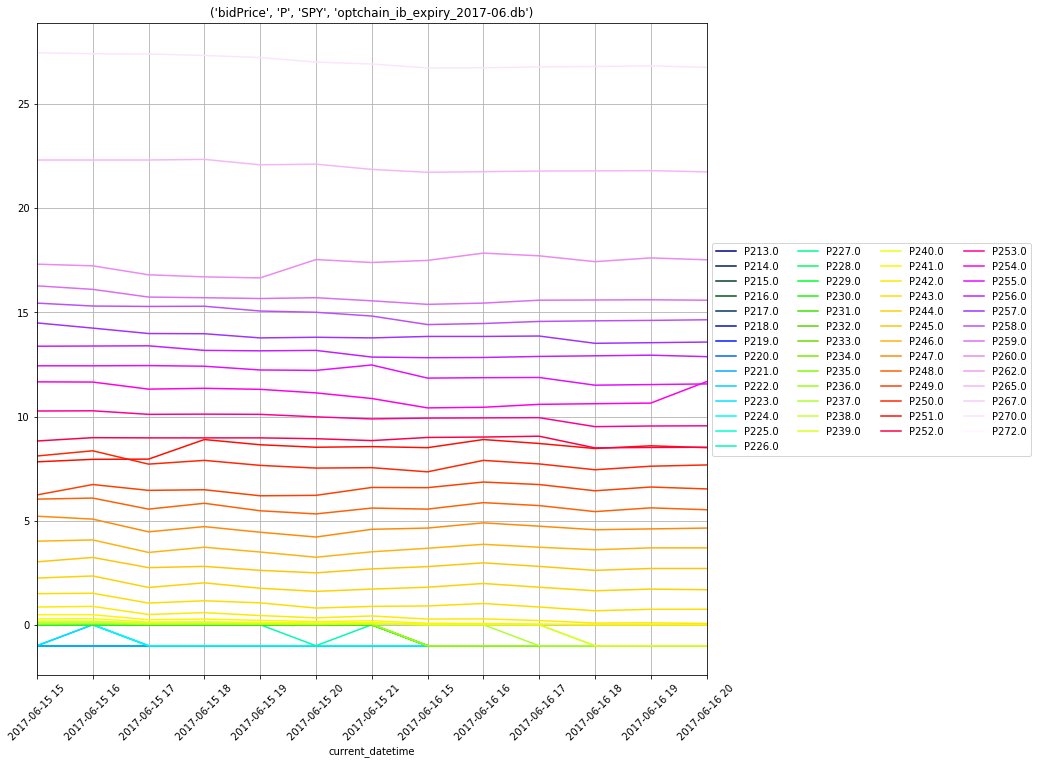

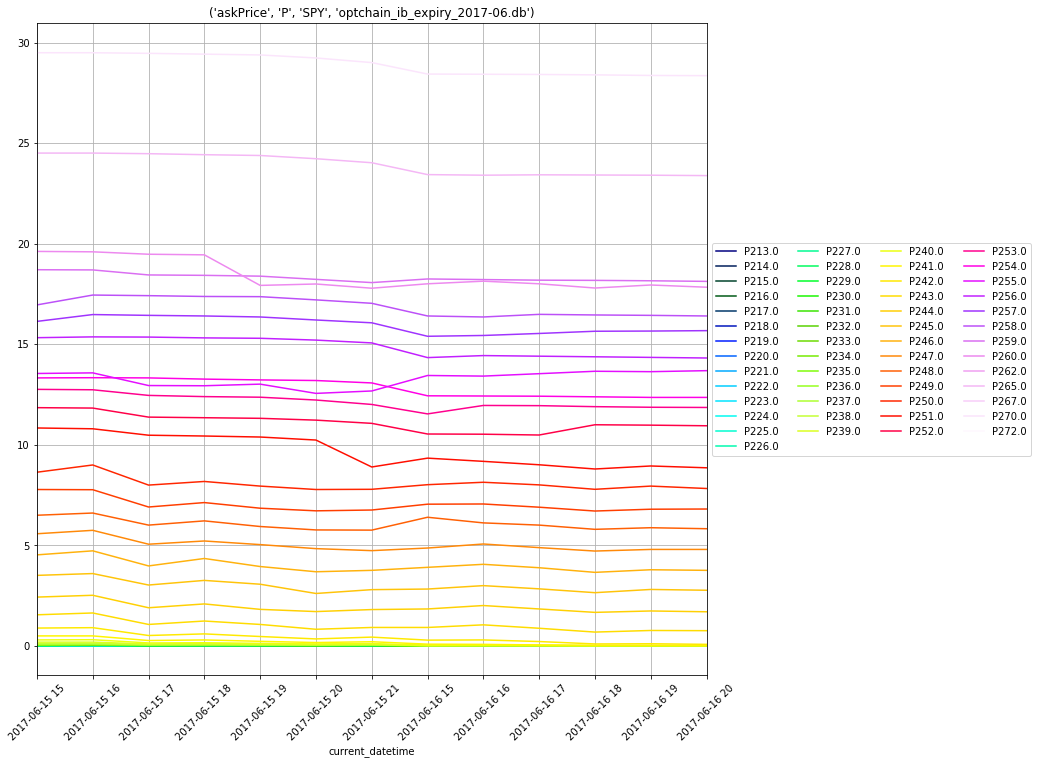

In [80]:
###########################################3
%matplotlib inline
import sys
sys.path.append("../")
###########################################3

import pandas as pd
import sqlite3
from volsetup.logger import logger
from volsetup import config
import operations.market_data as ddtt
import os
globalconf = config.GlobalConfig()
import numpy as np
from matplotlib.pyplot import *
log = logger("ipython")
symbols = ['ES','SPY']
expiries = ['2017-06','2017-07','2017-08','2017-09','2017-10','2017-11','2017-12','2018-01']
db_type = "optchain_ib"
path = globalconf.config['paths']['data_folder']
variables = ['lastOptPrice', 'bidImpliedVol',
       'modelTheta', 'askImpliedVol', 'bidPrice',
       'modelDelta', 'bidGamma', 'modelOptPrice', 'closePrice', 'highPrice',
       'askSize', 'CallOI', 'askOptPrice', 'Volume', 'modelImpliedVol',
       'lastTheta', 'askUndPrice', 'bidTheta', 'modelUndPrice',
       'askGamma', 'bidDelta', 'askVega', 'bidVega', 'modelVega',
       'lastUndPrice', 'bidOptPrice', 
       'askPrice', 'bidSize', 'lastDelta', 'askDelta', 
        'askTheta', 'lowPrice',
       'modelGamma', 'lastImpliedVol', 'lastGamma', 'PutOI', 'bidUndPrice',
       'lastVega', 'lastSize', 'lastPrice' ]
files = [x[2] for x in os.walk(path) if (x[2]) ][0]
filtered_files = [x for x in files if x.startswith(db_type)]
final_list = []
for file in filtered_files:
    for expiry in expiries:
        if expiry in file:
            final_list.append(file)
#print(("final_list = ", final_list))
df1 = pd.DataFrame()
for repo in final_list:
    #print("repo = " + repo)
    store = sqlite3.connect(path + repo)
    for symbol in symbols:
        #print("symbol = " + symbol)
        df1 = pd.read_sql_query("SELECT * FROM " + symbol 
                                + " where substr(current_datetime,1,8) in ('20170616','20170615')", store)
        df1.sort_values(by=['current_datetime'], inplace=True)
        #print("len(df1) = %d " % (len(df1)) )
        df1['optsymbol'] = df1.right.astype(str).str.cat(df1.strike.astype(str))
        for right in ['C','P']:
            df2 = df1[ (df1['right'] == right) ]
            for variable in variables:
                df2 = df2.drop_duplicates(subset=['current_datetime', 'symbol', 'right', 'strike','expiry'], keep='last')
                # transponer y poner en cada columna un precio
                #                   C       ....
                #                   2000.0  ...
                #                   Ask    Bid IVBid IVAsk ...
                df3 = df2.pivot(index='current_datetime', columns='optsymbol', values=variable)
                df3.index = pd.to_datetime(df3.index, format="%Y%m%d%H%M%S")
                df3 = df3.loc[:,:].apply(pd.to_numeric, errors='coerce')
                if not df3.empty:
                    fig, ax = subplots()
                    xticks = df3.index
                    ax.set_xticklabels([x.strftime('%Y-%m-%d %H') for x in xticks])
                    ax.set_xticks(np.arange(len(df3)), minor=False)
                    df3.plot(x=df3.index.to_series().dt.strftime('%Y-%m-%d %H'),
                             figsize=(12,12),
                             ax=ax,
                             grid=True,
                             colormap='gist_ncar', # https://matplotlib.org/examples/color/colormaps_reference.html
                             # xticks=xticks.to_pydatetime(),
                             # xticks=[x for x in df3.index.to_series().dt.strftime('%Y-%m-%d %H')],
                             rot=45,
                             title=str((variable,
                                        right,
                                        symbol,
                                        repo))).legend(ncol=4,loc='center left',bbox_to_anchor=(1, 0.5))
                
                    

In [81]:
df1.columns

Index(['index', 'right', 'lastOptPrice', 'modelPvDividend', 'bidImpliedVol',
       'lastPvDividend', 'modelTheta', 'askImpliedVol', 'currency', 'bidPrice',
       'modelDelta', 'bidGamma', 'modelOptPrice', 'closePrice', 'highPrice',
       'askSize', 'CallOI', 'askOptPrice', 'Volume', 'modelImpliedVol',
       'lastTheta', 'askUndPrice', 'bidTheta', 'strike', 'modelUndPrice',
       'askGamma', 'bidDelta', 'askVega', 'bidVega', 'exchange', 'modelVega',
       'symbol', 'expiry', 'lastUndPrice', 'bidOptPrice', 'multiplier',
       'askPrice', 'bidSize', 'lastDelta', 'askDelta', 'askPvDividend',
       'bidPvDividend', 'askTheta', 'comboLegsDescrip', 'secType', 'lowPrice',
       'modelGamma', 'lastImpliedVol', 'lastGamma', 'PutOI', 'bidUndPrice',
       'lastVega', 'lastSize', 'lastPrice', 'Halted', 'current_date',
       'current_datetime', 'optsymbol'],
      dtype='object')

In [54]:
df2 = df1[(df1['right'] == "C") & (df1['strike'].astype(float) == 2300.0)].dropna(subset=['lastPrice'])

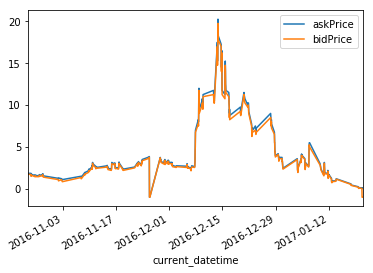

In [55]:

x_col = 'current_datetime'
y_cols = ['askPrice','bidPrice']
df2=df2.loc[:,[x_col] + y_cols].dropna()
df2.loc[:,y_cols] \
    = df2.loc[:,y_cols].apply(pd.to_numeric, errors='coerce')
df2.loc[:,x_col]=pd.to_datetime(df2.loc[:,x_col], format="%Y%m%d%H%M%S")
df2.index = df2[x_col]
del df2[x_col]
df2.plot()